In [26]:
import pandas as pd
from urllib.parse import unquote
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone

In [27]:
# Define a tuple of file paths and column names
files_and_columns = (
    ('data/paths_finished.tsv', ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating']),
    ('data/paths_unfinished.tsv', ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type']),
    ('data/articles.tsv', ['article']),
    ('data/categories.tsv', ['article', 'category'])
)

def read_files(file_tuples):
    dataframes = []
    for path, column_names in file_tuples:
        df = pd.read_csv(path, sep='\t', comment='#', names=column_names, header=None)
        dataframes.append(df)
    return dataframes

paths_finished, paths_unfinished, articles, categories  = read_files(files_and_columns)

## Cosine similarity on articles names

In [22]:
plain_text_articles =  open("data/plaintext_articles/2nd_century.txt", "r").read()
plain_text_articles

'   #copyright\n\n2nd century\n\n2007 Schools Wikipedia Selection. Related subjects: General history\n\n   Centuries:      1st century - 2nd century - 3rd century\n     Decades: 100s 110s 120s 130s 140s 150s 160s 170s 180s 190s\n\n   The 2nd century is the period from 101 - 200 in accordance with the\n   Julian calendar in the Christian Era.\n\nEvents\n\n   Pieces of Hadrian\'s Wall remain near Greenhead and along the route,\n   though large sections have been dismantled over the years to use the\n   stones for various nearby construction projects.\n   Enlarge\n   Pieces of Hadrian\'s Wall remain near Greenhead and along the route,\n   though large sections have been dismantled over the years to use the\n   stones for various nearby construction projects.\n     * 96–180: Five Good Emperors of Rome: Nerva, Trajan, Hadrian,\n       Antoninus Pius, Marcus Aurelius\n     * The kingdom of Aksum emerges\n     * 120-150: Bulgars migrate to Europe\n     * 122–132: Hadrian\'s Wall across Britai

In [ ]:
articles['article'] = articles['article'].apply(lambda x: unquote(x))
df_articles = articles.replace('_', ' ', regex=True)

In [29]:
from FlagEmbedding import BGEM3FlagModel
emb_model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True)

sentences = list(df_articles["article"])
embeddings = emb_model.encode(sentences)['dense_vecs']

article_embeddings = {article: embedding for article, embedding in zip(sentences, embeddings)}

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Inference Embeddings: 100%|██████████| 18/18 [01:48<00:00,  6.01s/it]


In [31]:
# paths_finished['path'] = paths_finished['path'].apply(lambda x: unquote(x))
paths = pd.DataFrame(paths_finished['path'].str.split(';'))
#select only paths with more than 2 links
paths = paths[paths['path'].apply(len) > 2]
# paths["path"] = paths["path"].apply(lambda x: [article.replace('_', ' ') for article in x])

In [32]:
import numpy as np
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def calculate_pairwise_similarities(row, embeddings):
    # Extract link names from columns (ignoring NaN values)
    links = [x for x in list(row)[0] if x != '<']
    # Retrieve embeddings for each link if available in `embeddings` dictionary
    link_embeddings = [embeddings[link] for link in links]
    # Calculate pairwise cosine similarity for all link embeddings in the path
    path_similarities = [
        cosine_similarity(link_embeddings[i], link_embeddings[j])
        for i in range(len(link_embeddings))
        for j in range(i + 1, len(link_embeddings))
    ]
    return path_similarities

paths['path_similarities'] = paths.apply(calculate_pairwise_similarities, embeddings=article_embeddings, axis=1)
paths

,path,path_similarities
0,"[14th_century, 15th_century, 16th_century, Pac...","[0.82727486, 0.77937555, 0.38145414, 0.3974124..."
1,"[14th_century, Europe, Africa, Atlantic_slave_...","[0.44778422, 0.3654997, 0.43178535, 0.4545195,..."
2,"[14th_century, Niger, Nigeria, British_Empire,...","[0.34886694, 0.27707168, 0.5069962, 0.49961078..."
3,"[14th_century, Renaissance, Ancient_Greece, Gr...","[0.4871284, 0.56050944, 0.39984336, 0.40757734..."
4,"[14th_century, Italy, Roman_Catholic_Church, H...","[0.39821193, 0.45485497, 0.35698175, 0.3674417..."
...,...,...
51313,"[Yagan, Ancient_Egypt, Civilization]","[0.3610433, 0.39076325, 0.48042306]"
51314,"[Yagan, Folklore, Brothers_Grimm, <, 19th_cent...","[0.36036575, 0.28633696, 0.32225373, 0.3176302..."
51315,"[Yagan, Australia, England, France, United_Sta...","[0.32573807, 0.37791204, 0.30484316, 0.3434634..."
51316,"[Yarralumla%2C_Australian_Capital_Territory, A...","[0.4879553, 0.3578209, 0.40599564, 0.52891284,..."


In [ ]:
from scipy.interpolate import interp1d

df_similarity = paths['path_similarities']
# upsample

median_length = int(df_similarity.apply(len).median())

# Function to resample each list to the median length
def resample_list(similarity_list, target_length):
    # Original indices of the list elements
    original_indices = np.linspace(0, 1, num=len(similarity_list))
    # New target indices for the resampled list
    target_indices = np.linspace(0, 1, num=target_length)
    # Interpolate the list to the target length
    interpolator = interp1d(original_indices, similarity_list, kind='linear')
    resampled_list = interpolator(target_indices)
    return resampled_list.tolist()

# Apply resampling to each list in df_similarity
resampled_similarity = df_similarity.apply(lambda x: resample_list(x, median_length))

# Convert the resampled lists to a DataFrame
paths['path_similarities_resample'] = resampled_similarity

In [13]:
paths

,path,path_similarities,path_similarities_resample
0,"[14th century, 15th century, 16th century, Pac...","[0.80419374, 0.74180835, 0.26095125, 0.2856094...","[0.8041937351226807, 0.2732803225517273, 0.342..."
1,"[14th century, Europe, Africa, Atlantic slave ...","[0.40646273, 0.34255123, 0.34399888, 0.3531365...","[0.40646272897720337, 0.3653767662388938, 0.34..."
2,"[14th century, Niger, Nigeria, British Empire,...","[0.31959552, 0.24834804, 0.4124344, 0.48009467...","[0.3195955157279968, 0.4007139450737408, 0.362..."
3,"[14th century, Renaissance, Ancient Greece, Gr...","[0.47674862, 0.4935335, 0.3719862, 0.36987805,...","[0.47674861550331116, 0.4827432142836707, 0.48..."
4,"[14th century, Italy, Roman Catholic Church, H...","[0.36971778, 0.3718822, 0.3356799, 0.25140825,...","[0.3697177767753601, 0.3563669238771711, 0.263..."
...,...,...,...
51313,"[Yagan, Ancient Egypt, Civilization]","[0.33616608, 0.39076325, 0.42931464]","[0.3361660838127136, 0.34396567940711975, 0.35..."
51314,"[Yagan, Folklore, Brothers Grimm, <, 19th cent...","[0.36036575, 0.2639344, 0.30568781, 0.32589903...","[0.36036574840545654, 0.3027054284300123, 0.36..."
51315,"[Yagan, Australia, England, France, United Sta...","[0.32573807, 0.37791204, 0.30484313, 0.3727933...","[0.3257380723953247, 0.3465967944690159, 0.363..."
51316,"[Yarralumla, Australian Capital Territory, Aus...","[0.52877843, 0.28234258, 0.27126387, 0.5360166...","[0.5287784337997437, 0.4407656299216407, 0.352..."


In [14]:
X = pd.DataFrame(paths['path_similarities_resample'].tolist())

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

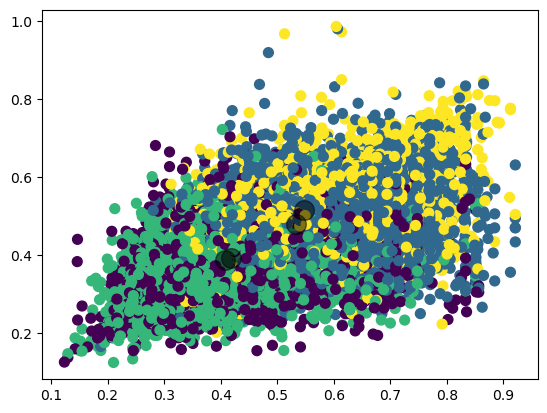

In [ ]:
plt.scatter(X[0], X[1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

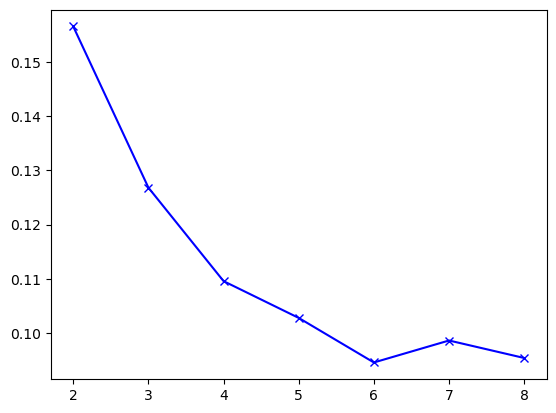

In [ ]:
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X)
    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg.append(silhouette_score(X, cluster_labels))
 
plt.plot(range_n_clusters,silhouette_avg,'bx-')
# plt.xlabel('Values of K') 
# plt.ylabel('Silhouette score') 
# plt.title('Silhouette analysis For Optimal k')
plt.show()

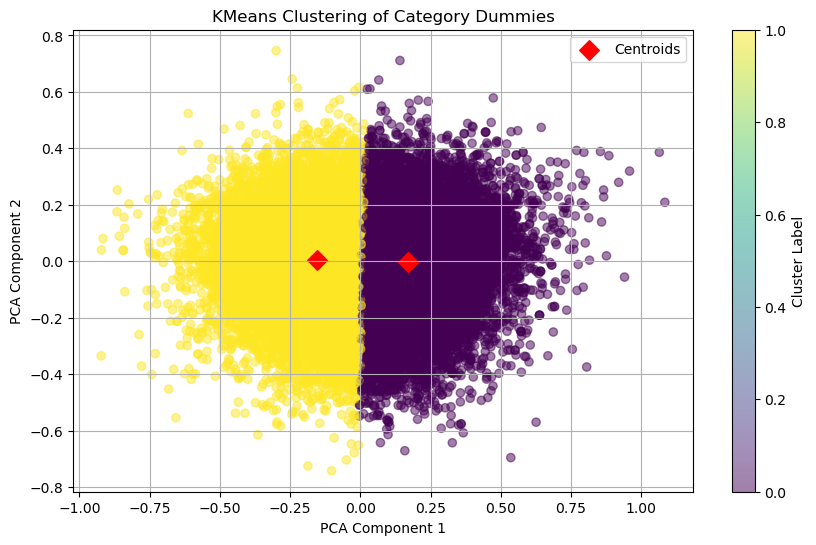

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Assuming 'category_dummies' is your one-hot encoded DataFrame with the category data
# For example, category_dummies could look something like this:
# category_dummies = pd.get_dummies(paths_with_categories[link_columns], prefix='', prefix_sep='')

# Step 1: Fit KMeans
n_clusters = 2 # Specify the number of clusters based on your analysis
model = KMeans(n_clusters=n_clusters, random_state=42)
model.fit(X)

# Step 2: Predict the cluster labels
labels = model.predict(X)

# Step 3: Perform PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X)

# Step 4: Prepare data for plotting
xs = reduced_data[:, 0]
ys = reduced_data[:, 1]

# Step 5: Create a scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(xs, ys, c=labels, alpha=0.5, cmap='viridis')

# Step 6: Plot cluster centroids
centroids = model.cluster_centers_
centroids_pca = pca.transform(centroids)  # Transform centroids to PCA space
centroids_x = centroids_pca[:, 0]
centroids_y = centroids_pca[:, 1]

plt.scatter(centroids_x, centroids_y, marker='D', s=100, color='red', label='Centroids')

# Add labels and title
plt.title('KMeans Clustering of Category Dummies')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.legend()
plt.grid(True)
plt.show()

## Cosine similarity on full articles

In [35]:
import os

directory = 'data/plaintext_articles'
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
print(len(files))

4604


In [ ]:
from FlagEmbedding import BGEM3FlagModel
emb_model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True)

article_embeddings = {}
for file in files[0:2]:
    article = open(f"{directory}/{file}", "r").read()
    article_embeddings[file] = emb_model.encode(article)['dense_vecs']

In [ ]:
# paths_finished['path'] = paths_finished['path'].apply(lambda x: unquote(x))
paths = pd.DataFrame(paths_finished['path'].str.split(';'))
#select only paths with more than 2 links
paths = paths[paths['path'].apply(len) > 2]
# paths["path"] = paths["path"].apply(lambda x: [article.replace('_', ' ') for article in x])

In [ ]:
import numpy as np
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def calculate_pairwise_similarities(row, embeddings):
    # Extract link names from columns (ignoring NaN values)
    links = [x for x in list(row)[0] if x != '<']
    # Retrieve embeddings for each link if available in `embeddings` dictionary
    link_embeddings = [embeddings[link] for link in links]
    # Calculate pairwise cosine similarity for all link embeddings in the path
    path_similarities = [
        cosine_similarity(link_embeddings[i], link_embeddings[j])
        for i in range(len(link_embeddings))
        for j in range(i + 1, len(link_embeddings))
    ]
    return path_similarities

paths['path_similarities'] = paths.apply(calculate_pairwise_similarities, embeddings=article_embeddings, axis=1)
paths

In [ ]:
from scipy.interpolate import interp1d

df_similarity = paths['path_similarities']
# upsample

median_length = int(df_similarity.apply(len).median())

# Function to resample each list to the median length
def resample_list(similarity_list, target_length):
    # Original indices of the list elements
    original_indices = np.linspace(0, 1, num=len(similarity_list))
    # New target indices for the resampled list
    target_indices = np.linspace(0, 1, num=target_length)
    # Interpolate the list to the target length
    interpolator = interp1d(original_indices, similarity_list, kind='linear')
    resampled_list = interpolator(target_indices)
    return resampled_list.tolist()

# Apply resampling to each list in df_similarity
resampled_similarity = df_similarity.apply(lambda x: resample_list(x, median_length))

# Convert the resampled lists to a DataFrame
paths['path_similarities_resample'] = resampled_similarity

In [ ]:
X = pd.DataFrame(paths['path_similarities_resample'].tolist())